# Imports

In [ ]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf

# gdrive
from google.colab import drive
drive.mount('/content/drive')

# modules
!cp "/content/drive/MyDrive/CVDL/modules/lib.py" .
import lib

!cp "/content/drive/MyDrive/CVDL/modules/plots.py" .
import plots

!cp "/content/drive/MyDrive/CVDL/modules/models/doubleunet.py" .
import doubleunet

!cp "/content/drive/MyDrive/CVDL/modules/models/dbunet_bn_2.py" .
import dbunet_bn_2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [ ]:
seed = 42

# dataset images res: 606x468px -> 1.2948
# og: input_res = (224, 160)
input_res = (384, 288)
#input_res = (224, 160)

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          #'learningRate': 8e-4,       
          'learningRate': 1e-3,              
          'momentum': 0.98,                        
          'nEpoches': 100,                        
          }

root_path = "/content/drive/MyDrive/CVDL/"
dumps_path =  "/content/drive/MyDrive/CVDL/dumps/"

# 80% training set, 10% test set, 10% val set
ratio_test = 0.8
ratio_val  = 0.9

#dataset  = "./Dataset" 
dataset  = "/content/drive/MyDrive/CVDL/dataset" 
type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

#gimmick
th_1 = 0.38
th_2 = 0.5

# get name of file imgs
imgs_list_path = os.listdir(path_img)

# ATTENTO | Data loading | ATTENTO

In [ ]:
# LOAD & SPLIT DATA ============================================================
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, dumps_path + "dataset_pat_split")

NameError: ignored

#Loading Data from Pickle

In [ ]:
#dataset_list = pickle.load(open( dumps_path + "dataset_pat_split", "rb" ))
#dataset_list = pickle.load(open( dumps_path + "splitted_data_224x160", "rb" ))
dataset_list = pickle.load(open( "/content/drive/MyDrive/CVDL/dumps/data_rt0.85_rv0.8_384x288", "rb" ))

#Data Augmentation

164 38


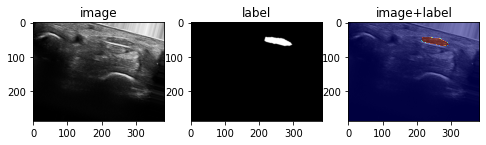

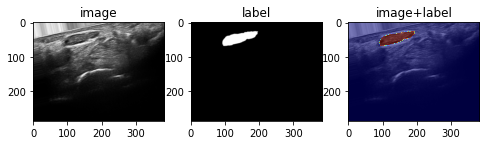

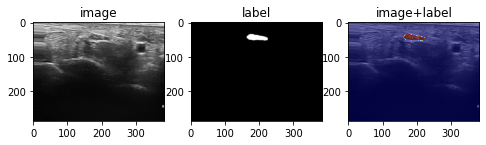

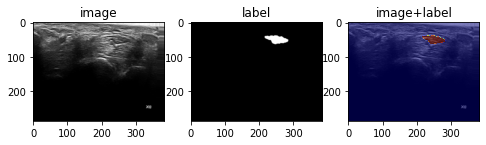

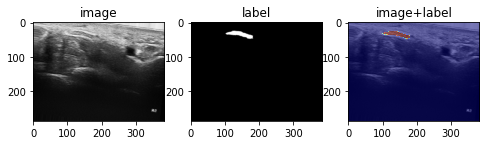

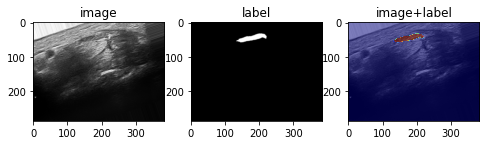

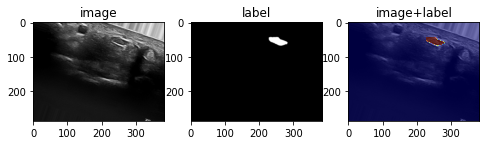

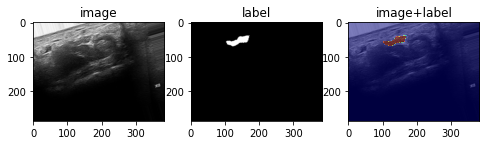

In [ ]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

print(params["length_training"], params["length_validation"])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

# Model definition

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint

input_size = (input_res[1], input_res[0], 1)

#model = dbunet_bn_2.build_model(tf.keras.initializers.HeNormal(seed=42), input_size)

model = doubleunet.build_model(input_size)

#model.summary()

# Metrics and Loss Functions

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

# Dice Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe

def clamp(n):
    if n < 0: return 0.0
    elif n > 1: return 1.0
    else: return n

def dice(output, target, loss_type='sorensen', axis=(1, 2, 3), smooth=1e-7):
  inse = tf.reduce_sum(output * target, axis=axis)
  
  if loss_type == 'jaccard':
      l = tf.reduce_sum(output * output, axis=axis)
      r = tf.reduce_sum(target * target, axis=axis)
  elif loss_type == 'sorensen':
      l = tf.reduce_sum(output, axis=axis)
      r = tf.reduce_sum(target, axis=axis)
  else:
      raise Exception("Unknow loss_type")

  dice = (2. * inse + smooth) / (l + r + smooth)
  #dice = clamp(tf.reduce_mean(dice, name='dice'))
  dice = tf.reduce_mean(dice, name='dice')
  
  return dice
'''

# Dice Coefficient
def dice(y_true, y_pred, smooth = 1e-7):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
'''
# IoU Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def iou(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the
    similarity of two batch of data, usually be used for evaluating binary image segmentation.
    The coefficient between 0 to 1, and 1 means totally match.
    
    Notes
    ------
    - IoU cannot be used as training loss, people usually use dice coefficient for training, 
      IoU and hard-dice for evaluating.
    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    
    batch_iou = (inse + smooth) / (union + smooth)
    #iou = clamp(tf.reduce_mean(batch_iou, name='iou'))
    iou = tf.reduce_mean(batch_iou, name='iou')

    return iou  # , pre, truth, inse, union

# Dice Loss
def dice_loss(output, target):
  return 1 - dice(output, target)

# BCE-Dice Loss
# source: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#BCE-Dice-Loss
def bce_dice_loss(output, target):
    return binary_crossentropy(output, target) + dice_loss(output, target)

# Hyperparameters Optimizing

In [ ]:
# Use scikit-learn to grid search the learning rate and momentum
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.metrics import *

# fix random seed for reproducibility
numpy.random.seed(seed)

#compile model
# compile
def compile_model(model):
  model.compile(optimizer = Adam(learning_rate = params["learningRate"]),
                               loss = bce_dice_loss,
                               metrics = [dice, iou])
  
  return model

model_2_check = compile_model(model)

# define the grid search parameters
learn_rate = [0.0002, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model_2_check, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
grid_result = grid.fit(dataset_list[0]['train'], dataset_list[1]['train'])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: ignored

# Callback #1

In [ ]:
# custom callback
class VisualizePreds(tf.keras.callbacks.Callback): 
  # constructor
  def __init__(self, val_data, patience=0):
      super(VisualizePreds, self).__init__()
      self.val_data = val_data

  # function at epoch end
  def on_epoch_end(self, epoch, logs=None):
    x, y = next(self.val_data)
    
    # first val image/mask
    val_img = x[0,:,:,0]
    val_msk = y[0,:,:,0]

    # re-shaping
    val_image = img_to_array(val_img)
    val_image = val_image.reshape((1, val_image.shape[0], val_image.shape[1], val_image.shape[2]))

    val_mask = img_to_array(val_msk)
    val_mask = val_mask.reshape((1, val_mask.shape[0], val_mask.shape[1], val_mask.shape[2]))
    
    # preds
    preds = self.model.predict(val_image) 
    # output 1
    output1 = preds[0][..., -2]
    output1[output1 >= th_2] = 1
    output1[output1 < th_2] = 0
    # output 2
    output2 = preds[0][..., -1]
    output2[output2 >= th_2] = 1
    output2[output2 < th_2] = 0
    #difference of 2 images
    diff = cv2.absdiff(output2, output1)

    # create figures
    rows = 1
    columns = 5

    fig = plt.figure(figsize=(25, 85))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(val_img, cmap='gray')
    plt.axis('off')
    plt.title("Input Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(output1, cmap='gray')
    plt.axis('off')
    plt.title("Output 1")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(output2, cmap='gray')
    plt.axis('off')
    plt.title("Output 2")
    fig.add_subplot(rows, columns, 4)
    plt.imshow(val_msk, cmap='gray')
    plt.axis('off')
    plt.title("Ground Truth")
    fig.add_subplot(rows, columns, 5)
    plt.imshow(diff, cmap='gray')
    plt.axis('off')
    plt.title("Difference")
    plt.show()

# Callback #2

In [ ]:
# custom callback
class VisualizeMultiply(tf.keras.callbacks.Callback): 
  # constructor
  def __init__(self, val_data, patience=0):
      super(VisualizeMultiply, self).__init__()
      self.val_data = val_data
  
  # function at epoch end
  def on_epoch_end(self, epoch, logs=None):
    x, y = next(self.val_data)
    
    # first val image/mask
    val_img = x[0,:,:,0]
    val_msk = y[0,:,:,0]

    # re-shaping
    val_image = img_to_array(val_img)
    val_image = val_image.reshape((1, val_image.shape[0], val_image.shape[1], val_image.shape[2]))

    # summarize model layers
    for count, layer in enumerate(model.layers):
      # check for multiply layer
      if 'tf.math.multiply' in layer.name: 
        layer_outputs = [layer.output for layer in model.layers[:count+2]] 
        mul_layer_index = count

    # Extracts the outputs
    # Creates a model that will return these outputs, given the model input
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

    # multiply
    activations = activation_model.predict(val_image) 
    mul_layer = activations[mul_layer_index]
    mul_img_1 = mul_layer[0,:,:,0]

    # output 1
    output1_pred = model.predict(val_image) 
    output1 = output1_pred[0][..., -2]

    # multiply layer
    mul_img_2 = val_img * output1

    # create figures
    rows = 1
    columns = 4

    fig = plt.figure(figsize=(25, 85))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(val_img, cmap='gray')
    plt.axis('off')
    plt.title("Input Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(output1, cmap='gray')
    plt.axis('off')
    plt.title("Output 1")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mul_img_1, cmap='gray')
    plt.axis('off')
    plt.title("Multiply Layer #1")
    fig.add_subplot(rows, columns, 4)
    plt.imshow(mul_img_2, cmap='gray')
    plt.axis('off')
    plt.title("Multiply Layer #2")
    plt.show()



# Model Training

In [ ]:
from tensorflow.keras.callbacks import *
from keras import models
from datetime import datetime
from tensorflow.keras.preprocessing.image import img_to_array

# weights path
model_weights_path = root_path + "dataset/results/weights/doubleunet" 

# callback list
callbacks_list = [
                  ModelCheckpoint(model_weights_path, 
                                  monitor = 'val_loss', 
                                  verbose = 2, 
                                  save_best_only = True, 
                                  mode = 'min'),
                  ReduceLROnPlateau(monitor='val_loss', 
                                    factor=0.1, 
                                    patience=10),
                  EarlyStopping(monitor='val_loss', 
                                patience=30, 
                                restore_best_weights=False),
                  VisualizePreds(val_generator)
                  ]

# compile
model.compile(optimizer = Adam(learning_rate = params["learningRate"]),
                               loss = bce_dice_loss,
                               metrics = [dice, iou])

# fit
history = model.fit(train_generator,
                    steps_per_epoch = (np.ceil(params["length_training"]/params["batch_size"])),
                    epochs = params["nEpoches"],
                    validation_data = val_generator,
                    verbose = 2,
                    validation_steps = (params['length_validation']/params["batch_size"]),
                    callbacks = [callbacks_list])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    # Test usando Keras.sum() ...
    #dice_numerator = K.sum(2 * im1 * im2, axis=(0, 1, 2)) + empty_score
    #dice_denominator = K.sum(im1, axis= axis) + K.sum(im2, axis =(0, 1, 2)) + empty_score
    #dice_coefficient = dice_numerator / dice_denominator

    return 2. * intersection.sum() / im_sum

output1 = cv2.imread("/content/drive/MyDrive/CVDL/wip/imgs/u2/u2_output1.png",0)
output2 = cv2.imread("/content/drive/MyDrive/CVDL/wip/imgs/u2/u2_output2.png",0)
mask = cv2.imread("/content/drive/MyDrive/CVDL/wip/imgs/u2/u2_mask.png",0)

print(dice(output2, mask))

0.9173387096774194


In [ ]:
#this saves the weights of the last epoch, only!
print("Saved model and weights in the directory")
model.load_weights(model_weights_path)

Saved model and weights in the directory


#Load best model 

In [ ]:
# modules
!cp "/content/drive/MyDrive/CVDL/modules/metrics.py" .
import metrics
from tensorflow import keras

loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

model = keras.models.load_model("/content/drive/MyDrive/CVDL/trained_models/dblunet/model.h5", custom_objects=c_objects)
model.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict=True)
model.summary()

2/2 [==============================] - 13s 4s/step - loss: 0.1147 - dice: 0.8860 - iou: 0.8145 - recall_2: 0.8499 - precision_2: 0.9460
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 384, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 288, 384, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 288, 384, 64) 1792

# Compare two outputs

In [ ]:
from keras import models
import copy
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np

# summarize model layers
for count, layer in enumerate(model.layers):
  # check for multiply layer
  if 'tf.math.multiply' in layer.name: 
    layer_outputs = [layer.output for layer in model.layers[:count]] 
    mul_layer_index = count - 1

# Extracts the outputs
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

for counti in range(0, len(dataset_list[0]['validation'])):
  # test image/mask 
  test_id = counti
  test_img = dataset_list[0]['validation'][test_id,:,:,0]
  test_mask = dataset_list[1]['validation'][test_id,:,:,0]

  '''
  test_image = img_to_array(test_img)
  test_image = test_image.reshape((1, test_image.shape[0],
                                     test_image.shape[1],
                                     test_image.shape[2]))
  '''

  # reshape test image to use it with .predict()
  test_image = np.reshape(test_img,[1,params["y"],params["x"],1])

  # output 1
  activations = activation_model.predict(test_image) 
  mul_layer = activations[mul_layer_index]
  output1 = mul_layer[0,:,:,0]
  output1[output1 >= th_1] = 1
  output1[output1 < th_1] = 0

  # output 2
  output2_pred = model.predict(test_image) 
  output2 = output2_pred[0,:,:,0]
  output2[output2 >= th_2] = 1
  output2[output2 < th_2] = 0

  #difference of 2 images
  diff = output1.copy()
  cv2.absdiff(output1, output2, diff)

  # create figures
  rows = 1
  columns = 5

  fig = plt.figure(figsize=(25, 85))
  fig.add_subplot(rows, columns, 1)
  plt.imshow(test_img, cmap='gray')
  plt.axis('off')
  plt.title("Input Image")
  fig.add_subplot(rows, columns, 2)
  plt.imshow(output1, cmap='gray')
  plt.axis('off')
  plt.title("Output 1")
  fig.add_subplot(rows, columns, 3)
  plt.imshow(output2, cmap='gray')
  plt.axis('off')
  plt.title("Output 2")
  fig.add_subplot(rows, columns, 4)
  plt.imshow(test_mask, cmap='gray')
  plt.axis('off')
  plt.title("Ground Truth")
  fig.add_subplot(rows, columns, 5)
  plt.imshow(diff, cmap='gray')
  plt.axis('off')
  plt.title("Difference")
  plt.show()

  print(counti)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
test_img_16 = dataset_list[0]['validation'][16,:,:,0]
test_mask_16 = dataset_list[1]['validation'][16,:,:,0]

plt.axis('off')
plt.title("Difference")
plt.show()
'''

output1 = cv2.imread("/content/drive/MyDrive/CVDL/wip/da_testare_1.png", 0)
output2 = cv2.imread("/content/drive/MyDrive/CVDL/wip/da_testare_2.png", 0)
mask = dataset_list[1]['validation'][16,:,:,0]

mask = cv2.resize(mask, (241, 181)) 

'''
#difference of 2 images
diff = output1.copy()
cv2.absdiff(output2, output1, diff)

plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.title("Difference")
plt.show()
'''

ndice = lib.dice(output2, mask)
print(ndice)

0.9063032367972743


In [ ]:
# print the layers shape
for indexx, x in enumerate(range(len(activations))):
  print(str(indexx) + " - " + str(activations[x].shape))

print(mul_layer_index)

# WIP

In [ ]:
from keras import models
import copy
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np

# summarize model layers
for count, layer in enumerate(model.layers):
  # check for multiply layer
  if 'tf.math.multiply' in layer.name: 
    layer_outputs = [layer.output for layer in model.layers[:count]] 
    mul_layer_index = count - 1

# Extracts the outputs
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

for counti in range(0, len(dataset_list[0]['validation'])):
  # test image/mask 
  test_id = counti
  test_img = dataset_list[0]['validation'][test_id,:,:,0]
  test_mask = dataset_list[1]['validation'][test_id,:,:,0]

  # re-shaping
  val_image = img_to_array(val_img)
  val_image = val_image.reshape((1, val_image.shape[0], val_image.shape[1], val_image.shape[2]))

  val_mask = img_to_array(val_msk)
  val_mask = val_mask.reshape((1, val_mask.shape[0], val_mask.shape[1], val_mask.shape[2]))

  # preds
  preds = self.model.predict(val_image) 
  # output 1
  output1 = preds[0][..., -2]
  output1[output1 >= th_2] = 1
  output1[output1 < th_2] = 0
  # output 2
  output2 = preds[0][..., -1]
  output2[output2 >= th_2] = 1
  output2[output2 < th_2] = 0
  #difference of 2 images
  diff = cv2.absdiff(output2, output1)

  # create figures
  rows = 1
  columns = 5

  fig = plt.figure(figsize=(25, 85))
  fig.add_subplot(rows, columns, 1)
  plt.imshow(val_img, cmap='gray')
  plt.axis('off')
  plt.title("Input Image")
  fig.add_subplot(rows, columns, 2)
  plt.imshow(output1, cmap='gray')
  plt.axis('off')
  plt.title("Output 1")
  fig.add_subplot(rows, columns, 3)
  plt.imshow(output2, cmap='gray')
  plt.axis('off')
  plt.title("Output 2")
  fig.add_subplot(rows, columns, 4)
  plt.imshow(val_msk, cmap='gray')
  plt.axis('off')
  plt.title("Ground Truth")
  fig.add_subplot(rows, columns, 5)
  plt.imshow(diff, cmap='gray')
  plt.axis('off')
  plt.title("Difference")
  plt.show()

# Results

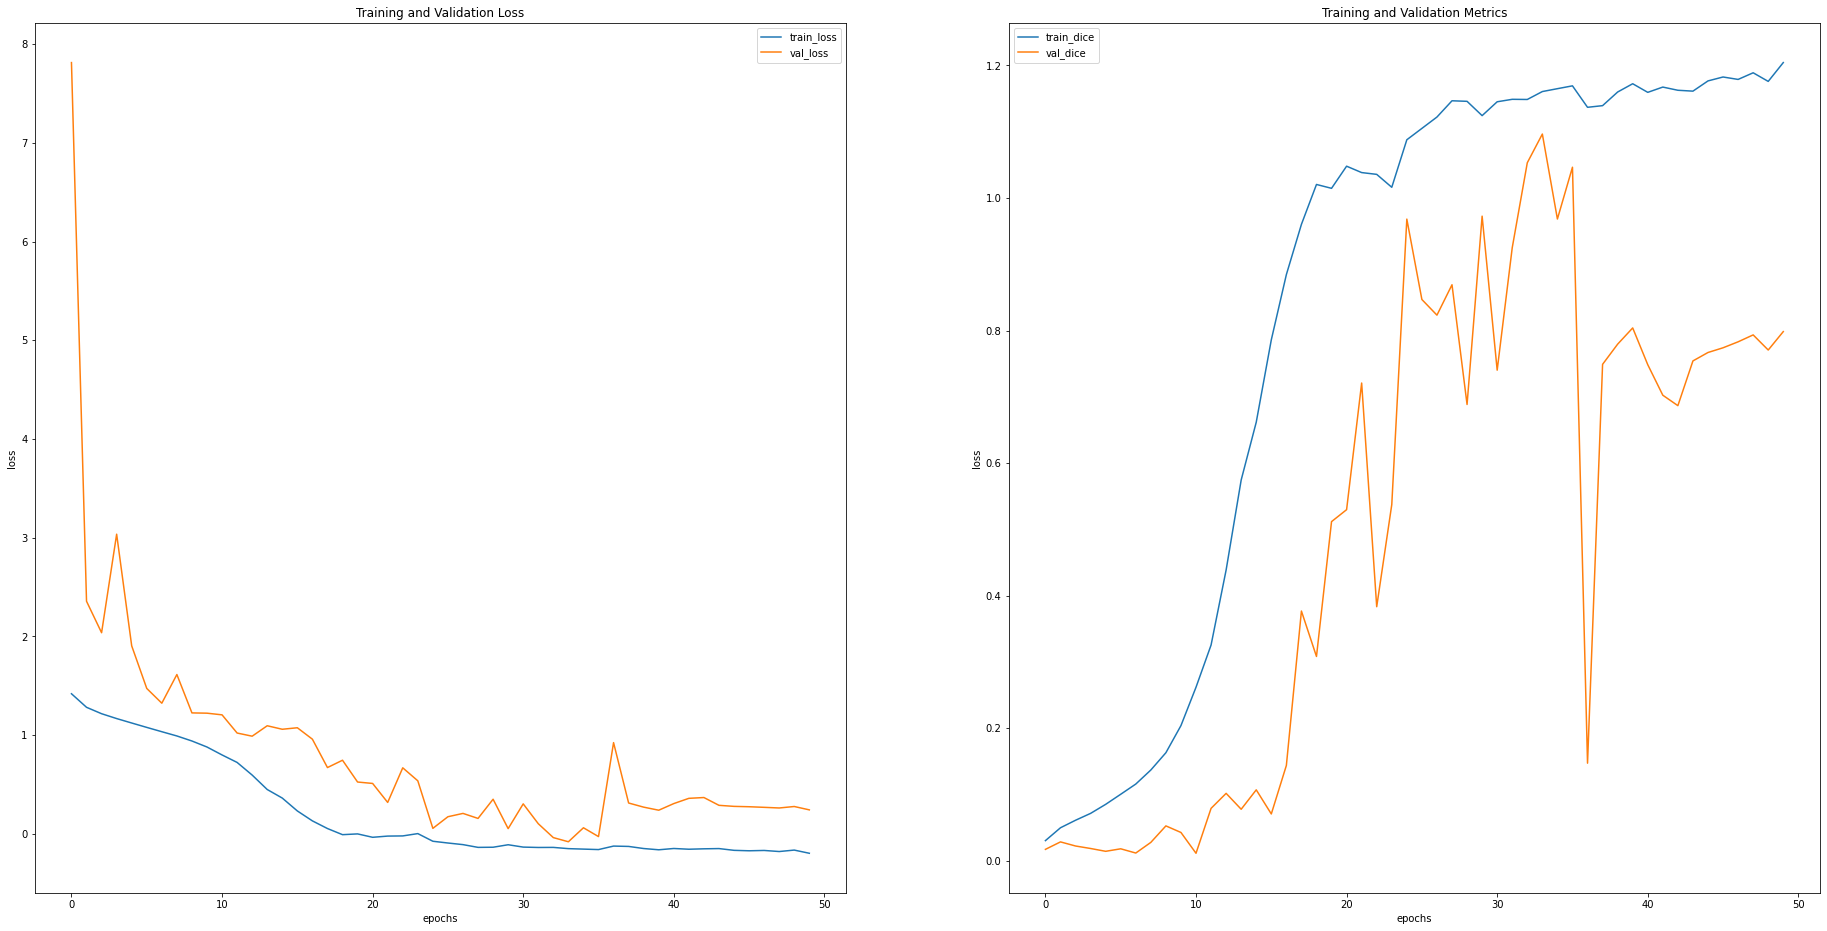

In [ ]:
# training and validation graph
train_figure = plots.plot_train_metric(history, params['nEpoches'], "dice")
plt.show()

# Testing results

In [ ]:
# Examine results
import pandas as pd

# Set the threshold for predictions
threshold = 0.5

# Select the image on which make 
results = {}
length_test = len(dataset_list[0]['test'])

for image_index in range (length_test):
    test_image = cv2.resize(dataset_list[0]['test'][image_index,:,:,0],(params["x"],params["y"]))
    test_mask = cv2.resize(dataset_list[1]['test'][image_index,:,:,0],(params["x"],params["y"]))
    test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
    results[image_index] = {'dice': lib.dice(test_mask, test_results["pred_mask"])}

results

{0: {'dice': 0.9237041351193943},
 1: {'dice': 0.8654585392641406},
 2: {'dice': 0.9135071090047393},
 3: {'dice': 0.9117647058823529},
 4: {'dice': 0.9356060606060606},
 5: {'dice': 0.9496919917864476},
 6: {'dice': 0.9040247678018576},
 7: {'dice': 0.9082125603864735},
 8: {'dice': 0.924956369982548},
 9: {'dice': 0.9201623815967523},
 10: {'dice': 0.8303571428571429},
 11: {'dice': 0.8594470046082949},
 12: {'dice': 0.9186991869918699},
 13: {'dice': 0.015485407980941036},
 14: {'dice': 0.8629320619785459},
 15: {'dice': 0.9047292666209733},
 16: {'dice': 0.9202247191011236},
 17: {'dice': 0.8916030534351145},
 18: {'dice': 0.8384358896635344},
 19: {'dice': 0.5803411131059246},
 20: {'dice': 0.8960915157292659},
 21: {'dice': 0.8442260442260442},
 22: {'dice': 0.9237875288683602},
 23: {'dice': 0.9374398460057748},
 24: {'dice': 0.8843873517786561},
 25: {'dice': 0.9084880636604774},
 26: {'dice': 0.9090909090909091},
 27: {'dice': 0.8918918918918919},
 28: {'dice': 0.0},
 29: {'di

In [ ]:
results_df = pd.DataFrame(results).transpose()
print(results_df['dice'].mean())

0.8241284781389314


testing accuracy: 0.9865792410714286
testing dice: 0.935093509350935


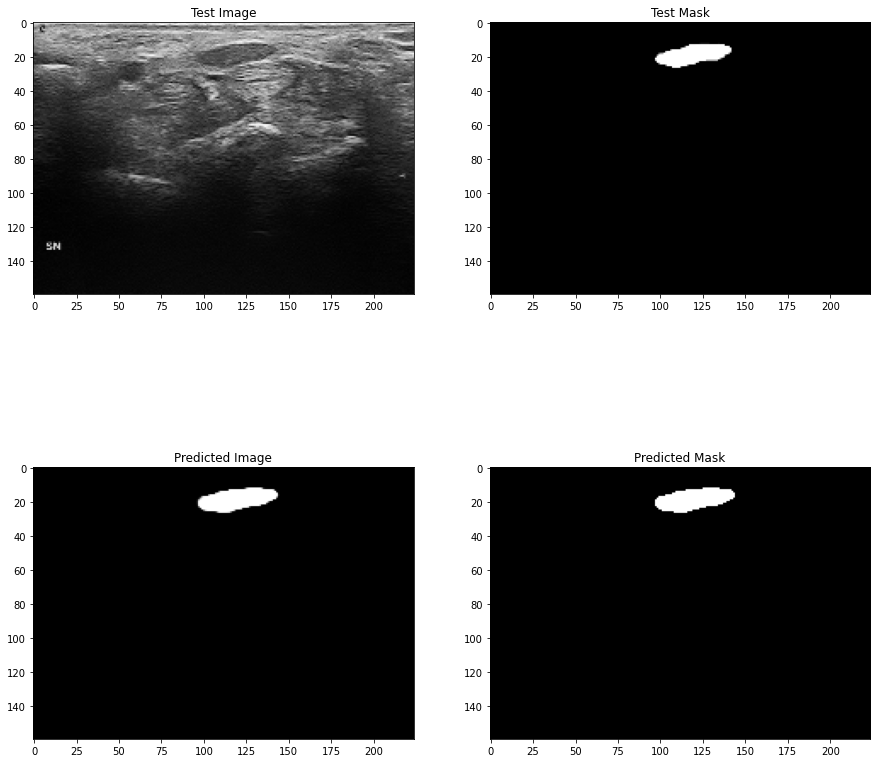

In [ ]:
# Examine results

# Set the threshold for predictions
threshold = 0.5
# Select the image on which make 
image_index = 4
test_image = cv2.resize(dataset_list[0]['test'][image_index,:,:,0],(params["x"],params["y"]))
test_mask = cv2.resize(dataset_list[1]['test'][image_index,:,:,0],(params["x"],params["y"]))

test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)

print("testing accuracy:", lib.accuracy(test_mask, test_results["pred_mask"]))
print("testing dice:", lib.dice(test_mask, test_results["pred_mask"]))

results_figure = plots.plot_test_results(test_results)
plt.show()